In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso , LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os

In [67]:
loan_stats = pd.read_csv('LoanStats_07_11_Clean.csv')
print(loan_stats.shape)
print(loan_stats.head())

(38971, 38)
   loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  installment  \
0       5000         5000           4975.0  36_months    0.1065       162.87   
1       2500         2500           2500.0  60_months    0.1527        59.83   
2       2400         2400           2400.0  36_months    0.1596        84.33   
3      10000        10000          10000.0  36_months    0.1349       339.31   
4       3000         3000           3000.0  60_months    0.1269        67.79   

  grade sub_grade                 emp_title emp_length  ... total_pymnt_inv  \
0     B        B2                       NaN  10+ years  ...         5833.84   
1     C        C4                     Ryder   < 1 year  ...         1014.53   
2     C        C5                       NaN  10+ years  ...         3005.67   
3     C        C1       AIR RESOURCES BOARD  10+ years  ...        12231.89   
4     B        B5  University Medical Group     1 year  ...         4066.91   

   total_rec_prncp total_rec_int

In [40]:
print(loan_stats.describe())
print(loan_stats.isnull().sum())


          loan_amnt   funded_amnt  funded_amnt_inv     int_rate   installment  \
count  38971.000000  38971.000000     38971.000000  38971.00000  38971.000000   
mean   11267.289138  10991.212697     10567.339566      0.12045    325.102015   
std     7479.466536   7205.758465      7111.024059      0.03745    208.862742   
min      500.000000    500.000000         0.000000      0.05420     16.080000   
25%     5500.000000   5500.000000      5000.000000      0.09250    167.420000   
50%    10000.000000   9800.000000      9000.000000      0.11860    280.910000   
75%    15000.000000  15000.000000     14500.000000      0.14610    431.365000   
max    35000.000000  35000.000000     35000.000000      0.24590   1305.190000   

         annual_inc           dti   delinq_2yrs  inq_last_6mths      open_acc  \
count  3.897100e+04  38971.000000  38971.000000    38971.000000  38971.000000   
mean   6.903752e+04     13.367816      0.145416        0.865849      9.301558   
std    6.315848e+04      6.

### EDA

The data has very few missing values as it has been cleaned. "emp_title" and "emp_length" are the only missing variables. Providing the "job title" and "length of employment" respectively are generally unimportant when considering the quality of loan on behalf of a large firm. We intend to target pre-investment variables, not information provided post-loan as that would introduce bias. We want to be able to predict post-loan outcomes from pre-loan measurables. 

1. We are choosing to heavily focus on Grades and Loan Status as outcomes. Grades serve as an ecompassing metric to assess how risky the loan is. Loan Status considers loans that have been paid off (good) and charged off (bad because LC has lost money due to the client not being able to pay back the loan). 

2. 
Median loan amount: $10,000.00

Average loan amount: $11,267.29

Average interest rate: 0.12%

Average Debt to Income Ratio: 13.37% 

4. 

### Investor return summary

| Metric                          | Mean    | Median  |
|---------------------------------|---------|---------|
| Dollar gained per dollar funded | 1.1064  | 1.1523  |
| ROI gross (investor and LC)     | 10.64%  | 15.23%  |
| Investor ROI                    | 10.38%  | 14.75%  |
| principal recovery              | 91.06%  | 100%    |
| interest yield per loan                 | 18.79%  | 16.78%  |
| net gain per loan               | 1,306.1955 | 1,133.5886 |

**Total portfolio net gain:** $50,903,743.35

Cash_multiple shows how many dollars came back per dollar funded; values above 1 indicate positive gross return .

ROI gross is the cash multiple minus one and is easy to compare across loans.
Investor ROI uses the investor-funded portion and highlights fee/timing differences versus total cash flows.

Principal recovery indicates capital protection, while interest yield isolates the income component.

net_gain explains the "expected" raw dollar profit per loan. A positive value means payments received exceed principal amount; zero means break‑even; negative means a loss. This is before portions are split between Lending Club and the investment firm

Total portfolio is the aggregate of profits from providing loans. ~$51 million in profits is a good sign. We are making money through providing loans and collecting interest rate payments. 

These are important metrics to determine if it is worthwhile to invest in Lending Club. 



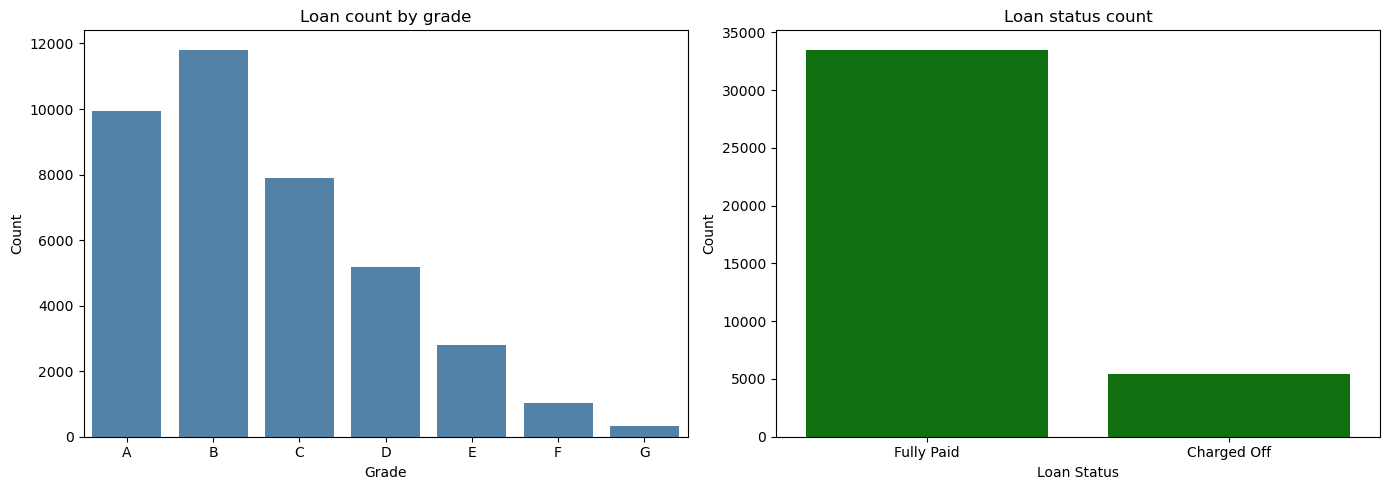

In [41]:
# Examining a histogram of Grading and Loan status

ls = loan_stats.copy()
grade_order = ['A','B','C','D','E','F','G']

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data=ls, x='grade', order=grade_order, color='steelblue', ax=axes[0])
axes[0].set_title('Loan count by grade')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Count')

sns.countplot(data=ls, x='loan_status', color='green', ax=axes[1])
axes[1].set_title('Loan status count')
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [62]:
# Median and mean loan amount, average interest rate, average DTI 

median_loan_amt = ls['loan_amnt'].median()
mean_loan_amt = ls['loan_amnt'].mean()
mean_int_rate = ls['int_rate'].astype(str).str.rstrip('%').astype(float).mean()
mean_dti = ls['dti'].mean()

print(f"Median loan amount: ${median_loan_amt:,.2f}")
print(f"Average loan amount: ${mean_loan_amt:,.2f}")
print(f"Average interest rate: {mean_int_rate:.2f}%")
print(f"Average Debt to Income Ratio: {mean_dti:.2f}%")

Median loan amount: $10,000.00
Average loan amount: $11,267.29
Average interest rate: 0.12%
Average Debt to Income Ratio: 13.37%


In [63]:
# How much do we stand to gain per loan

funded = ls['funded_amnt'].replace(0, np.nan) 
funded_inv = ls['funded_amnt_inv'].replace(0, np.nan)

# Per-loan metrics
ls['cash_multiple'] = ls['total_pymnt'] / funded                      # $ back per $ funded
ls['roi_gross'] = ls['cash_multiple'] - 1                         # gross ROI
ls['roi_investor'] = (ls['total_pymnt_inv'] / funded_inv) - 1        # ROI on investor-funded portion
ls['principal_recovery'] = ls['total_rec_prncp'] / funded                  # capital returned / capital funded
ls['interest_yield'] = ls['total_rec_int'] / funded                    # interest earned / capital funded
ls['net_gain']  = ls['total_pymnt'] - ls['funded_amnt']           # dollar profit (pre-fees)

# This is a summary of investor metrics
summary_inv = ls[['cash_multiple','roi_gross','roi_investor','principal_recovery','interest_yield','net_gain']].agg(['mean','median']).T
print(summary_inv.round(4))

# total net gain
total_portfolio_net_gain = ls['net_gain'].sum()
print(f"Total portfolio net gain: ${total_portfolio_net_gain:,.2f}")



                         mean     median
cash_multiple          1.1064     1.1523
roi_gross              0.1064     0.1523
roi_investor           0.1038     0.1475
principal_recovery     0.9106     1.0000
interest_yield         0.1879     0.1678
net_gain            1306.1955  1133.5886
Total portfolio net gain: $50,903,743.35


Cash multiple shows how many dollars came back per dollar funded; values above 1 indicate positive gross return.

ROI gross is the cash multiple minus one and is easy to compare across loans.
Investor ROI uses the investor-funded portion and highlights fee/timing differences versus total cash flows.

Principal recovery indicates capital protection, while interest yield isolates the income component.

net_gain explains the "expected" raw dollar profit per loan. A positive value means payments received exceed principal amount; zero means break‑even; negative means a loss. This is before portions are split between Lending Club and the investment firm

Total portfolio is the aggregate of profits from providing loans. ~$51 million in profits is a good sign. We are making money through providing loans and collecting interest rate payments. 

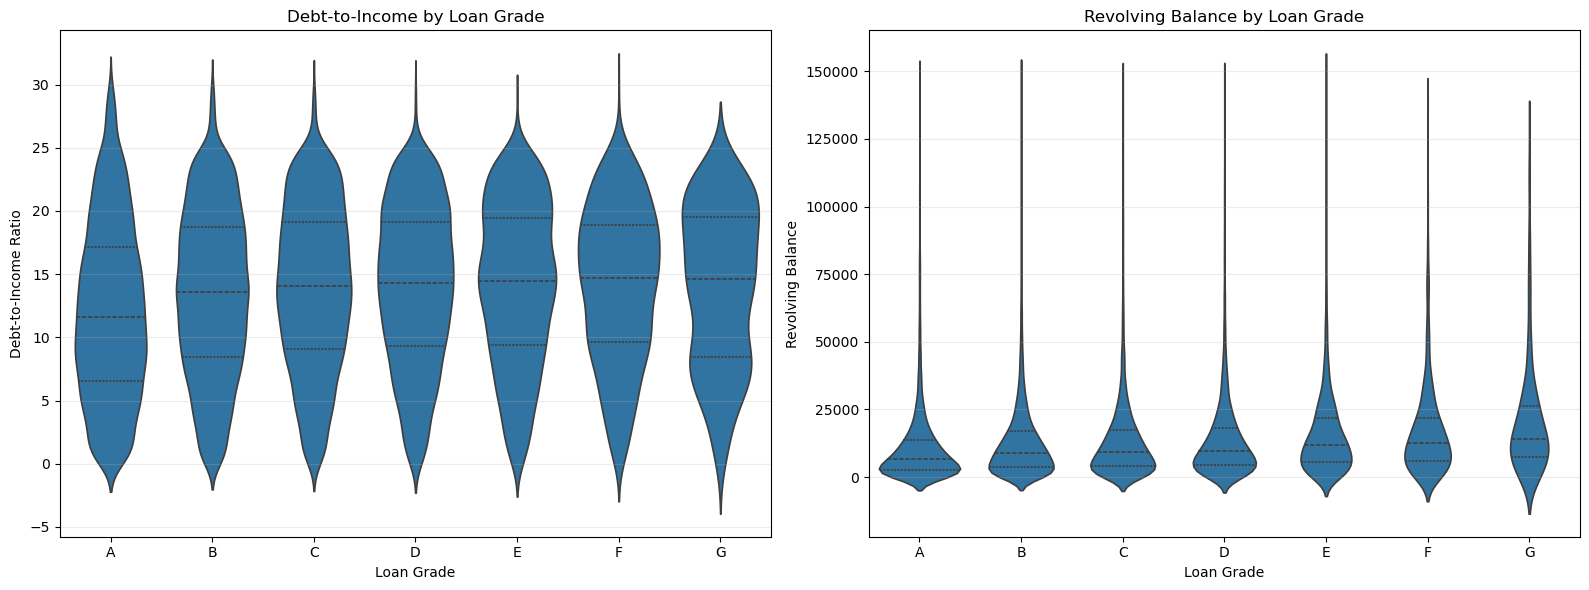

DTI by Grade in %:
       count  median   mean
grade                      
A       9937   11.63  12.14
B      11810   13.61  13.50
C       7889   14.08  13.92
D       5185   14.30  14.00
E       2805   14.47  14.10
F       1033   14.67  14.13
G        312   14.63  14.03

Revolving Balance by Grade:
       count   median      mean
grade                          
A       9937   6844.0  11404.43
B      11810   9084.0  13426.10
C       7889   9306.0  13610.30
D       5185   9526.0  14147.67
E       2805  11859.0  16308.39
F       1033  12488.0  17383.25
G        312  14044.0  20650.35


In [44]:
# Violtin plots DTI and Revolving Balance by Loan Grade 

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.violinplot(data=ls, x='grade', y='dti', order=grade_order, inner='quartile', ax=axes[0])
axes[0].set_title('Debt-to-Income by Loan Grade')
axes[0].set_xlabel('Loan Grade')
axes[0].set_ylabel('Debt-to-Income Ratio')
axes[0].grid(axis='y', alpha=0.25)

sns.violinplot(data=ls, x='grade', y='revol_bal', order=grade_order, inner='quartile', ax=axes[1])
axes[1].set_title('Revolving Balance by Loan Grade')
axes[1].set_xlabel('Loan Grade')
axes[1].set_ylabel('Revolving Balance')
axes[1].grid(axis='y', alpha=0.25)

plt.tight_layout()
plt.show()

# Summary stats by grade
summary_dti = ls.groupby('grade')['dti'].agg(['count','median','mean']).reindex(grade_order)
summary_revol_bal = ls.groupby('grade')['revol_bal'].agg(['count','median','mean']).reindex(grade_order)
print("DTI by Grade in %:")
print(summary_dti.round(2))
print("\nRevolving Balance by Grade:")
print(summary_revol_bal.round(2))

These violin plots show variation, density, and quartiles of DTI and revolving balance by loan grade. Higher-quality grades (A, B, C) exhibit lower median DTI and revolving balances, while lower grades (D–G) show higher debt burdens and credit utilization, reflecting increased default risk.

### Feature Separation: Pre-loan vs. Post-loan
To ensure our model predicts default risk based only on information available *at the time of investment*, we explicitly separate features into pre-loan (predictors) and post-loan (leakage).

**Pre-loan Features (Safe to use):**
*   `loan_amnt`: Amount applied for.
*   `term`: Loan duration (36 or 60 months).
*   `int_rate`: Interest rate on the loan.
*   `installment`: Monthly payment.
*   `grade`, `sub_grade`: LC assigned risk grade.
*   `emp_length`: Employment duration.
*   `home_ownership`: Housing status.
*   `annual_inc`: Self-reported annual income.
*   `verification_status`: Income verification status.
*   `purpose`: Loan purpose.
*   `dti`: Debt-to-income ratio.
*   `delinq_2yrs`: Past-due incidences.
*   `earliest_cr_line`: Credit history start date.
*   `inq_last_6mths`: Recent credit inquiries.
*   `open_acc`: Number of open credit lines.
*   `pub_rec`: Derogatory public records.
*   `revol_bal`: Total credit revolving balance.
*   `revol_util`: Revolving line utilization rate.
*   `total_acc`: Total credit lines.
*   `pub_rec_bankruptcies`: Public record bankruptcies.

**Post-loan Features (Leakage - Must Exclude):**
*   `funded_amnt`, `funded_amnt_inv`: Total amount committed (often known at issuance, but `inv` portion depends on investor uptake).
*   `total_pymnt`, `total_pymnt_inv`: Payments received to date.
*   `total_rec_prncp`: Principal received.
*   `total_rec_int`: Interest received.
*   `total_rec_late_fee`: Late fees received.
*   `recoveries`, `collection_recovery_fee`: Post-charge-off recoveries.
*   `last_pymnt_d`, `last_pymnt_amnt`: Last payment details.
*   `last_credit_pull_d`: Most recent credit pull.
*   `out_prncp`, `out_prncp_inv`: Outstanding principal.
*   *Derived Metrics*: `net_gain`, `roi_gross`, `roi_investor`, `cash_multiple`, `principal_recovery`, `interest_yield`.

In [45]:
# Define pre-loan (predictor) variables
pre_loan_vars = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'pub_rec_bankruptcies'
]

# post-loan (leakage/outcome) 
post_loan_vars = [
    'funded_amnt', 'funded_amnt_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
    'last_credit_pull_d', 'out_prncp', 'out_prncp_inv',
    # Derived metrics
    'net_gain', 'roi_gross', 'roi_investor', 'cash_multiple',
    'principal_recovery', 'interest_yield'
]


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re

# 1. Data Preparation
# Filter for binary outcome: 'Fully Paid' vs 'Charged Off'
ls = loan_stats[loan_stats['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

# Create binary target: 1 for 'Charged Off' (Default/Bad), 0 for 'Fully Paid' (Good)
ls['target'] = ls['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

# Clean numeric columns that are currently strings
def clean_percent(x):
    if isinstance(x, str):
        return float(x.strip('%'))
    return x

ls['int_rate'] = ls['int_rate'].apply(clean_percent)
ls['revol_util'] = ls['revol_util'].apply(clean_percent)

# Clean 'term' (extract number of months)
def clean_term(x):
    if isinstance(x, str):
        match = re.search(r'\d+', x)
        if match:
            return int(match.group())
    return x

ls['term'] = ls['term'].apply(clean_term)

# Select predictors from pre_loan_vars
# Excluding 'earliest_cr_line' to avoid complex date parsing for this initial model
predictors = [p for p in pre_loan_vars if p not in ['earliest_cr_line']]

X = ls[predictors]
y = ls['target']

# Handle categorical variables (One-Hot Encoding)
# drop_first=True to avoid multicollinearity
X = pd.get_dummies(X, drop_first=True)

# Handle missing values
# Dropping rows with any missing values for a clean baseline
X = X.dropna()
y = y[X.index]

print(f"Data shape after cleaning: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

# 2. Train/Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Scaling (Important for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Lasso Logistic Regression with CV
# penalty='l1' for Lasso
print("Training Lasso Logistic Regression CV...")
lasso_cv = LogisticRegressionCV(
    cv=5, 
    penalty='l1', 
    solver='liblinear', 
    random_state=42,
    max_iter=1000,
    scoring='accuracy'
)

lasso_cv.fit(X_train_scaled, y_train)

# 5. Evaluation
y_pred = lasso_cv.predict(X_test_scaled)

print(f"Best C (Inverse of Lambda): {lasso_cv.C_[0]}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Data shape after cleaning: (38971, 82)
Target distribution:
target
0    0.859691
1    0.140309
Name: proportion, dtype: float64
Training Lasso Logistic Regression CV...
Best C (Inverse of Lambda): 0.005994842503189409
Accuracy: 0.8599

Confusion Matrix:
 [[10049     3]
 [ 1635     5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92     10052
           1       0.62      0.00      0.01      1640

    accuracy                           0.86     11692
   macro avg       0.74      0.50      0.47     11692
weighted avg       0.83      0.86      0.80     11692



In [47]:
from sklearn.linear_model import LogisticRegression

# penalty=None removes regularization
full_lr = LogisticRegression(penalty=None, max_iter=2000, random_state=42) 
full_lr.fit(X_train_scaled, y_train)

# 2. Create Comparison DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso_Coef': lasso_cv.coef_[0],
    'Full_Reg_Coef': full_lr.coef_[0]
})

# Calculate absolute difference
coef_df['Abs_Diff'] = (coef_df['Lasso_Coef'] - coef_df['Full_Reg_Coef']).abs()

# Sort by absolute magnitude of Lasso coefficients
coef_df_sorted = coef_df.reindex(coef_df['Lasso_Coef'].abs().sort_values(ascending=False).index)

# 3. Print Results
print("\n--- Top 20 Predictors (Sorted by Lasso Magnitude) ---")
print(coef_df_sorted[['Feature', 'Lasso_Coef', 'Full_Reg_Coef']].head(20).to_string(index=False))

# Count zeroed features
zeroed_features = coef_df[coef_df['Lasso_Coef'] == 0]
print(f"\nTotal features: {len(coef_df)}")
print(f"Features selected by Lasso: {len(coef_df) - len(zeroed_features)}")


Training Standard Logistic Regression (Full Model)...

--- Top 20 Predictors (Sorted by Lasso Magnitude) ---
               Feature  Lasso_Coef  Full_Reg_Coef
              int_rate    0.350800       0.459975
            annual_inc   -0.240905      -0.525282
                  term    0.185061       0.223764
purpose_small_business    0.117137       0.218804
        inq_last_6mths    0.088180       0.142625
            revol_util    0.075949       0.136365
   purpose_credit_card   -0.031973      -0.007265
               pub_rec    0.023941       0.050256
          sub_grade_F5    0.017854       0.043185
       purpose_wedding   -0.012337      -0.033413
  pub_rec_bankruptcies    0.009778       0.024942
         purpose_other    0.003358       0.131940
               grade_D    0.000832       0.061633
          sub_grade_G1    0.000000      -0.002825
    emp_length_8 years    0.000000      -0.025868
          sub_grade_G2    0.000000      -0.000043
          sub_grade_G3    0.000000       

In [48]:
# Demonstration of feature expansion
print(f"Original categorical columns: {['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'emp_length']}")
print(f"Number of columns after One-Hot Encoding: {X.shape[1]}")
print("\nBreakdown of dummy variables:")
for col in ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'emp_length']:
    # Count columns that start with the original column name
    count = sum([1 for c in X.columns if c.startswith(col + '_')])
    print(f" - {col}: {count} new features")

Original categorical columns: ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'emp_length']
Number of columns after One-Hot Encoding: 82

Breakdown of dummy variables:
 - grade: 6 new features
 - sub_grade: 34 new features
 - home_ownership: 3 new features
 - verification_status: 2 new features
 - purpose: 13 new features
 - emp_length: 10 new features


We started with only 20 pre-loan variables. There are now 82 features due to dummy coding for categorical data.

When we ran `pd.get_dummies(X, drop_first=True)`, each category within a text variable became its own binary (0/1) column. Here is the breakdown:

1.  **`sub_grade`**: This is the biggest contributor. There are 35 sub-grades (A1-G5). Dropping one leaves 24 columns. The problem with "sub_grade" is that is "meta" in that there is going to be multicollinearity. We are trying to predict the quality of a loan. This is a metric that is alreayd doing that.
2.  **`purpose`**: There are about 14 loan purposes (e.g., 'debt_consolidation', 'small_business'). This adds 13 columns.
3.  **`emp_length`**: 11 categories (<1 year to 10+ years). Adds 10 columns.
4.  **`grade`**: 7 grades (A-G). Adds **6 columns**.
5.  **`home_ownership`**: Adds 3 columns.
6.  **`verification_status`**: Adds 2 columns.




In [49]:
# Adjusting Class Weights to handle imbalance
# class_weight='balanced' automatically adjusts weights inversely proportional to class frequencies
print("Training Lasso Logistic Regression with Class Weights='balanced'...")

lasso_balanced = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced', 
    random_state=42,
    max_iter=1000,
    scoring='accuracy'
)

lasso_balanced.fit(X_train_scaled, y_train)

# Evaluation
y_pred_balanced = lasso_balanced.predict(X_test_scaled)

print(f"Best C (Balanced): {lasso_balanced.C_[0]}")
print(f"Accuracy (Balanced): {accuracy_score(y_test, y_pred_balanced):.4f}")
print("\nConfusion Matrix (Balanced):\n", confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report (Balanced):\n", classification_report(y_test, y_pred_balanced))

Training Lasso Logistic Regression with Class Weights='balanced'...
Best C (Balanced): 0.0001
Accuracy (Balanced): 0.8597

Confusion Matrix (Balanced):
 [[10052     0]
 [ 1640     0]]

Classification Report (Balanced):
               precision    recall  f1-score   support

           0       0.86      1.00      0.92     10052
           1       0.00      0.00      0.00      1640

    accuracy                           0.86     11692
   macro avg       0.43      0.50      0.46     11692
weighted avg       0.74      0.86      0.79     11692



/Users/danielnickas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielnickas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielnickas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

However, looking at the output:
Even with class_weight='balanced', the model with Lasso regularization (penalty='l1') ended up selecting a very strong regularization parameter (C=0.0001, which is a very high lambda). This effectively zeroed out all coefficients, resulting in a "null model" that predicts the majority class for everyone again (Recall for class 1 is still 0.00).

This often happens when the signal in the data is weak relative to the noise, and the strong regularization combined with the penalty for misclassification forces the model to be extremely conservative.

Next Steps to fix this:

Relax Regularization: Try a standard Logistic Regression (no penalty) with class_weight='balanced' to see if it can find a signal without being crushed by the Lasso penalty.
Adjust Threshold: Instead of using the default 0.5 probability threshold, we can lower the threshold (e.g., to 0.3 or 0.4) to catch more defaults, trading off some precision.
Would you like me to try one of these approaches?

In [50]:
# 1. Relax Regularization: Standard Logistic Regression with Class Weights
print("Training Standard Logistic Regression (No Penalty) with Class Weights='balanced'...")

# penalty=None removes regularization
lr_balanced = LogisticRegression(
    penalty=None, 
    class_weight='balanced', 
    max_iter=2000, 
    random_state=42
)

lr_balanced.fit(X_train_scaled, y_train)

# Evaluation
y_pred_lr_balanced = lr_balanced.predict(X_test_scaled)

print(f"Accuracy (Balanced LR): {accuracy_score(y_test, y_pred_lr_balanced):.4f}")
print("\nConfusion Matrix (Balanced LR):\n", confusion_matrix(y_test, y_pred_lr_balanced))
print("\nClassification Report (Balanced LR):\n", classification_report(y_test, y_pred_lr_balanced))

Training Standard Logistic Regression (No Penalty) with Class Weights='balanced'...
Accuracy (Balanced LR): 0.6454

Confusion Matrix (Balanced LR):
 [[6500 3552]
 [ 594 1046]]

Classification Report (Balanced LR):
               precision    recall  f1-score   support

           0       0.92      0.65      0.76     10052
           1       0.23      0.64      0.34      1640

    accuracy                           0.65     11692
   macro avg       0.57      0.64      0.55     11692
weighted avg       0.82      0.65      0.70     11692



Recall Improvement: The most important change is that Recall for 'Charged Off' jumped from 0% to 64%. The model now correctly identifies 1,046 out of 1,640 bad loans, whereas the previous model missed almost all of them.
Overall accuracy dropped to 64.5%, but this is a more "honest" accuracy for a risk model. The previous 86% accuracy was useless because it just ignored risk entirely.


In [66]:
# Re-calculate financial metrics for the current ls dataframe (to ensure they exist for the test set)
funded = ls['funded_amnt'].replace(0, np.nan) 
funded_inv = ls['funded_amnt_inv'].replace(0, np.nan)

ls['cash_multiple'] = ls['total_pymnt'] / funded
ls['roi_gross'] = ls['cash_multiple'] - 1
ls['roi_investor'] = (ls['total_pymnt_inv'] / funded_inv) - 1
ls['principal_recovery'] = ls['total_rec_prncp'] / funded
ls['interest_yield'] = ls['total_rec_int'] / funded
ls['net_gain'] = ls['total_pymnt'] - ls['funded_amnt']

# Get predictions from the balanced model on the test set
y_pred_balanced = lr_balanced.predict(X_test_scaled)

# Select loans predicted as 'Fully Paid' (Class 0)
# 0 = Fully Paid, 1 = Charged Off
selected_indices = y_test.index[y_pred_balanced == 0]
selected_loans = ls.loc[selected_indices]

# Calculate summary metrics for the selected portfolio
metrics = ['cash_multiple','roi_gross','roi_investor','principal_recovery','interest_yield','net_gain']
summary_balanced = selected_loans[metrics].agg(['mean','median']).T



In [65]:
print("--- Expected Metrics for Portfolio Selected by Balanced Logistic Regression ---")
print(summary_balanced.round(4))

# Total Net Gain for the selected portfolio
total_gain_balanced = selected_loans['net_gain'].sum()
print(f"\nTotal Portfolio Net Gain (Balanced Model): ${total_gain_balanced:,.2f}")
print(f"Number of Loans Selected: {len(selected_loans)}")
print(f"Selection Rate: {len(selected_loans) / len(y_test):.2%}")

# test set
baseline_loans = ls.loc[y_test.index]
summary_baseline = baseline_loans[metrics].agg(['mean']).T
print("All test loans")
print(summary_baseline.round(4))

total_gain_baseline = baseline_loans['net_gain'].sum()
print(f"\nTotal Portfolio Net Gain (Baseline): ${total_gain_baseline:,.2f}")
print(f"Number of Loans Selected: {len(baseline_loans)}")

--- Expected Metrics for Portfolio Selected by Balanced Logistic Regression ---
                         mean    median
cash_multiple          1.0984    1.1262
roi_gross              0.0984    0.1262
roi_investor           0.0959    0.1247
principal_recovery     0.9519    1.0000
interest_yield         0.1419    0.1326
net_gain            1121.0420  962.6950

Total Portfolio Net Gain (Balanced Model): $7,952,672.09
Number of Loans Selected: 7094
Selection Rate: 60.67%
All test loans
                         mean
cash_multiple          1.1065
roi_gross              0.1065
roi_investor           0.1038
principal_recovery     0.9107
interest_yield         0.1874
net_gain            1319.0885

Total Portfolio Net Gain (Baseline): $15,422,783.16
Number of Loans Selected: 11692
